# Finding Chinese Compounds
<ul style='font-size: large'>
    <li>The goal is to find compounds having two bisyllabic NN constituents. </li>
    <li>Last time, we found just selecting 4-character words would have too much "noise": <br>there are some 4-character words don't look like compounds.</li>
    <li>Use a constituency parse to help us find good candidates (with Stanford CoreNLP Chinese model). </li>
    <li>In the parse tree, find the NP tree nodes with two bisyllabic NN leaf-nodes.</li>
</ul>

In [1]:
import sys
sys.path.append("../src")
import os
import re
import json
import svgling
from itertools import islice
from collections import Counter
from opencc import OpenCC
from tqdm.auto import tqdm
from stanza.server import CoreNLPClient
from stanford_utils import *


In [2]:
os.environ["CORENLP_HOME"] = os.path.expanduser("~/etc/stanford-corenlp-4.4.0")
t2s = OpenCC('t2s.json')

In [3]:
with CoreNLPClient(properties="chinese",
        annotators=['tokenize','ssplit','pos','parse'],
        timeout=30000,        
        memory='6G', be_quiet=True) as client:    
    ann1 = client.annotate(t2s.convert("電話號碼"))
    ann2 = client.annotate(t2s.convert("分享給新進住民以及研究人員參考。"))

2022-03-07 15:22:49 INFO: Using CoreNLP default properties for: chinese.  Make sure to have chinese models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2022-03-07 15:22:49 INFO: Starting server with command: java -Xmx6G -cp /home/seantyh/etc/stanford-corenlp-4.4.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties chinese -annotators tokenize,ssplit,pos,parse -preload -outputFormat serialized


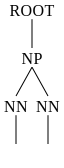

In [4]:
svgling.draw_tree(to_linear(ann1.sentence[0].parseTree))

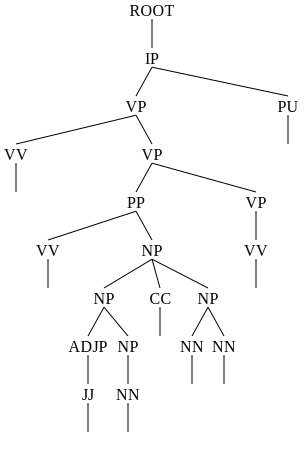

In [5]:
svgling.draw_tree(to_linear(ann2.sentence[0].parseTree))

## Approach I. Parse a corpus, and find NP compounds in the parse trees

<ul style='font-size: large'>
  <li>ASBC from Academia Sinica (corpus size: 15M characters)</li>
  <li>Chinese Wikipedia 2019 preprocessed data dump from a <a href="https://github.com/brightmart/nlp_chinese_corpus">GitHub</a>.<br>Only 4% of the wikipedia data are used, which include 18M characters</li>
    <li>As Stanford CoreNLP only supports simplified Chinese, all text inputs are first converted to simplified Chinese.</li>
    <li>Parsing requires 2.5~3 hrs for each corpus.</li>
    
</ul>

### Compounds from ASBC

In [6]:
!wc -l ../data/asbc_compounds_nn2.csv

117073 ../data/asbc_compounds_nn2.csv


In [7]:
!head -10 ../data/asbc_compounds_nn2.csv

idx,np,nptype,w1,w2,p1,p2,freq
18,工作人员,22,工作,人员,NN,NN,302
20,研究人员,22,研究,人员,NN,NN,285
25,社会大众,22,社会,大众,NN,NN,261
29,百货公司,22,百货,公司,NN,NN,248
30,公务人员,22,公务,人员,NN,NN,245
33,校务会议,22,校务,会议,NN,NN,235
36,地方政府,22,地方,政府,NN,NN,213
38,政治大学,22,政治,大学,NN,NN,205
44,主办单位,22,主办,单位,NN,NN,190


### Compounds from Wikipedia

In [8]:
!wc -l ../data/wiki2019_compounds_nn2.csv

106750 ../data/wiki2019_compounds_nn2.csv


In [9]:
!head -10 ../data/wiki2019_compounds_nn2.csv

idx,np,nptype,w1,w2,p1,p2,freq
1,"人口密度",22,"人口","密度","NN","NN",4326
7,"政治人物",22,"政治","人物","NN","NN",1277
9,"世界大战",22,"世界","大战","NN","NN",853
11,"生活习性",22,"生活","习性","NN","NN",612
12,"人民政府",22,"人民","政府","NN","NN",555
17,"热带风暴",22,"热带","风暴","NN","NN",410
23,"热带气旋",22,"热带","气旋","NN","NN",320
25,"进士出身",22,"进士","出身","NN","NN",305
26,"操作系统",22,"操作","系统","NN","NN",302


## Approach 2. Find 4-char words in FastText vocabulary, and select NN compounds with their parse trees

<ul style='font-size: large'>
  <li>It looks like only a fraction of the nn compounds extracted from asbc/wiki could be found in FastText.</li>
  <li>If we need the FastText embeddings, maybe we should start with the FastText vocabulary.</li>
  <li>First, find the 4-character words in the FastText vocabulary, and make sure all of them have their first two characters and their last two characters are also in FastText's vocabulary.</li>
    <li>Parse the 4-character "words", and only select those having two bisyllabic NNs.</li>
    <li>The implicit assumption is that the parse tree of these 4-character words are the same with or without sentential contexts</li>
</ul>

In [10]:
!wc -l ../data/qsylls_fasttext.csv    

126587 ../data/qsylls_fasttext.csv


In [11]:
!head -20 ../data/qsylls_fasttext.csv | paste - - - - - -d' '   

非會員試 平方公里 中華民國 澳大利亚 社会主义
另一方面 马来西亚 维基百科 除此之外 巴基斯坦
与此同时 阿里巴巴 為輻鰭魚 免費視訊 奥林匹克
不好意思 绝大多数 哥伦比亚 翻譯而來 各种各样


In [19]:
with CoreNLPClient(properties="chinese",
        annotators=['tokenize','ssplit','pos','parse'],
        timeout=30000,        
        memory='6G', be_quiet=True) as client:    
    ann3 = client.annotate(t2s.convert("奥林匹克"))
    ann4 = client.annotate(t2s.convert("平方公里"))
    ann5 = client.annotate(t2s.convert("另一方面"))
    ann6 = client.annotate(t2s.convert("免費視訊"))
    ann7 = client.annotate(t2s.convert("電視動畫"))
    

2022-03-07 15:37:17 INFO: Using CoreNLP default properties for: chinese.  Make sure to have chinese models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2022-03-07 15:37:17 INFO: Starting server with command: java -Xmx6G -cp /home/seantyh/etc/stanford-corenlp-4.4.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties chinese -annotators tokenize,ssplit,pos,parse -preload -outputFormat serialized


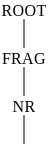

In [20]:
svgling.draw_tree(to_linear(ann3.sentence[0].parseTree))

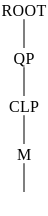

In [21]:
svgling.draw_tree(to_linear(ann4.sentence[0].parseTree))

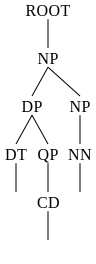

In [22]:
svgling.draw_tree(to_linear(ann5.sentence[0].parseTree))

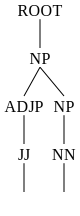

In [23]:
svgling.draw_tree(to_linear(ann6.sentence[0].parseTree))

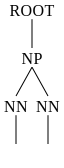

In [24]:
svgling.draw_tree(to_linear(ann7.sentence[0].parseTree))

In [17]:
!wc -l ../data/fasttext_compounds_nn2.csv  

21914 ../data/fasttext_compounds_nn2.csv


In [18]:
!head -20 ../data/fasttext_compounds_nn2.csv | paste - - - - - -d'\t'   

汽车,旅馆,NN,NN	热带,气旋,NN,NN	日治,时期,NN,NN	综艺,节目,NN,NN	个人,标签,NN,NN
创业,贷款,NN,NN	铁路,车站,NN,NN	平板,电脑,NN,NN	经济,发展,NN,NN	电视,动画,NN,NN
苹果,日报,NN,NN	讯息,简述,NN,NN	服务,条款,NN,NN	百货,公司,NN,NN	国家,公园,NN,NN
消费,会员,NN,NN	采购,讯息,NN,NN	营业,时间,NN,NN	劲歌,金曲,NN,NN	班级,经营,NN,NN
